# 3 時間目
# フィルタを使って学習機械を作ってみよう

それでは，最後の時間では，現代 AI の核心技術となりつつあるフィルタを使ったネットワーク，畳み込みニューラルネットワーク (Convolution Neural Network) を実現してみましょう．

１時間目と２時間目では，視覚システムにおいて畳み込み（フィルタ）演算が重要な役割を担っていそうということを学びました．
ただし，フィルタを設計するには，なんらかの指針が必要でした．

サルやヒトの初期視覚システムの研究では，微分型のような特徴抽出するフィルタと，局所的な積分形のようなフィルタが組み合わさって構成されていそうだということがわかっています．ただし，実際に特徴抽出となると，その設計は難しくなってしまいます．
そこで，フィルタの係数は，データから決めましょうという考え方が出てきました．このようにデータから（フィルタの係数のような）パラメータを決めることを　*学習* などと呼びます．

ここでは，

1. フィルタの枠組みを設計して
2. 得られた表現を，判別するような学習機械をつなぎ合わせ
3. データからの学習によって，全体のパラメータを調整する

という方法を取っていくこととします．

先程までは `numpy` や `scipy` といった，科学技術演算パッケージを用いてきましたが，ここでは *機械学習/深層学習* をメインに取り扱うため，そのために設計された `keras` と呼ばれるパッケージを用います．

In [27]:
# とりあえずはおまじない
import numpy as np
import matplotlib.pylab as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

## データを用意する．

ここでは手始めに MNIST と呼ばれる数字文字のデータセットを使って実験を行います．
MNIST は 28x28 画素という比較的小さい画像の中に手書きの数字が書かれたデータセットです．ただしその画像枚数は多く，70,000枚が内包されています．

よく使うやり方は，60,000 枚のデータをパラメータの学習に用いて，残りの 10,000 枚は，できた機械がどの程度の性能を持つかをテストするために用います．以下では，

* `x_train` に学習用の数字データ
* `y_train` に上記学習データのラベル （'0'から '9' までの値）
* `x_test` にテスト用の数字データ
* `y_test` に上記テストデータのラベル

としてデータを用います．

データ自体は keras の中に用意されています．`keras.datasets` の中にある `mnist` モジュールを使うと便利です．

In [35]:
from keras.datasets import mnist

(x_train, y_train_label), (x_test, y_test_label) = mnist.load_data()

# このままだと扱いにくいので画像データは [0, 1] の値を持つデータにします．
x_train = x_train.astype('float32').reshape(60000, 28, 28, 1)
x_test = x_test.astype('float32').reshape(10000, 28, 28, 1)
x_train /= 255
x_test /= 255

# ラベルデータもちょっと扱いにくいので 10 要素のベクトルで表す (one-hot vector 表現)
# この表現は，
# ラベルが '0' であれば [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# ラベルが '1' であれば [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
# ラベルが '2' であれば [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
# といった表現になる

y_train = keras.utils.to_categorical(y_train_label)
y_test = keras.utils.to_categorical(y_test_label)

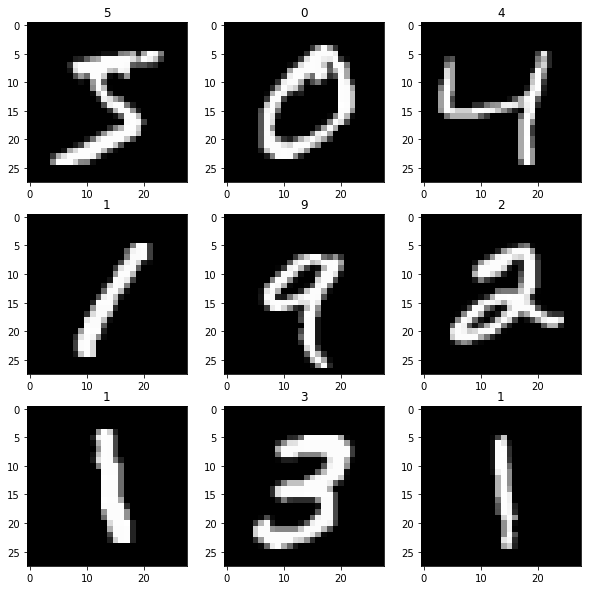

In [37]:
# 試しに最初の 9 個くらいを描画してみる

plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_train[i, :, :, 0], cmap='gray')
    plt.title(y_train_label[i])


## 視覚モデルを構築してみる．

まずは，初期視覚野的なモデルを考えてみましょう．初期視覚野のモデルは，いくつかの特徴抽出を行うフィルタと，それぞれをぼかすフィルタから成り立っています．ここでは，適当に入力画像を 32 種類のフィルタで分解しておき，それぞれをぼかすような形の枠組みを考えてみます．
`model` という変数に作っていきます．

とりあえず，

* 特徴抽出のフィルタは 5x5 とし，32種類，
* 特徴抽出後は正の値のみを通す (Rectified Linear (ReLU)と呼ばれる演算です)
* ぼかす操作(MaxPoolingが対応)は，フィルタで 2x2 の範囲をぼかすような形で作ってみることにします


In [52]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), input_shape=(28, 28, 1)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

ここまでで，視覚に使われているような表現になっていると思うことにしましょう．
次に，この表現を分類器にかけてみます．分類器も `model` に追加していくことで一つの学習機械を定義することができます．

In [53]:
# 分類器，とりあえずはおまじないと思っておｋ

model.add(Flatten()) # 上記表現を1列のベクトルに並べて
model.add(Dense(10, activation='softmax')) # 識別器を構成

## モデルの学習

さて，ここまででモデルができました．でもフィルタの係数とかは決まってません．この部分を学習で決めることにします．
学習自体は，ある種の関数(loss関数と呼ばれます)を小さくすることで求めます．
ここでは `categorical_crossentropy` と呼ばれるを loss 関数としています．

In [54]:
from keras.optimizers import Adam

# 学習モデルを定義して
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# 学習させます
history = model.fit(x_train, y_train, batch_size=128, epochs=20, verbose=1)

Epoch 1/20
60000/60000 [==============================] - 8s 140us/step - loss: 0.4213 - acc: 0.8841
Epoch 2/20
60000/60000 [==============================] - 8s 139us/step - loss: 0.1924 - acc: 0.9455
Epoch 3/20
60000/60000 [==============================] - 8s 141us/step - loss: 0.1387 - acc: 0.9619
Epoch 4/20
60000/60000 [==============================] - 9s 142us/step - loss: 0.1091 - acc: 0.9694
Epoch 5/20
60000/60000 [==============================] - 9s 142us/step - loss: 0.0909 - acc: 0.9747
Epoch 6/20
60000/60000 [==============================] - 9s 144us/step - loss: 0.0790 - acc: 0.9779
Epoch 7/20
60000/60000 [==============================] - 9s 146us/step - loss: 0.0709 - acc: 0.9795
Epoch 8/20
60000/60000 [==============================] - 9s 146us/step - loss: 0.0634 - acc: 0.9815
Epoch 9/20
60000/60000 [==============================] - 9s 149us/step - loss: 0.0591 - acc: 0.9829
Epoch 10/20
60000/60000 [==============================] - 9s 152us/step - loss: 0.0544 - a

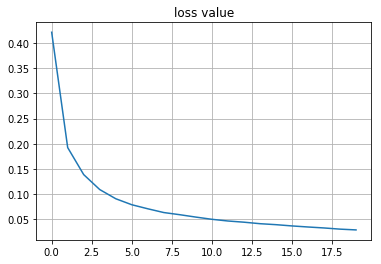

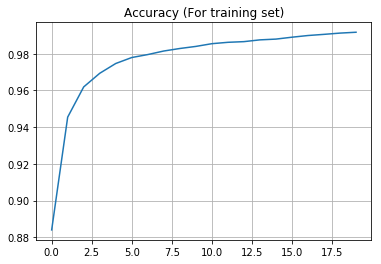

In [55]:
# loss の値
plt.figure()
plt.plot(history.history['loss'])
plt.title('loss value')
plt.grid()


# 学習データに対する正答率
plt.figure()
plt.plot(history.history['acc'])
plt.title('Accuracy (For training set)')
plt.grid()


学習データセットに関しては 99 % 程度の精度で識別できていることがわかります．．
次にテストセットで評価してみましょう．

In [58]:
# テストセットで評価してみる

score = model.evaluate(x_test, y_test, verbose=1)

print('test loss: ', score[0])
print('test accuracy: ', score[1])

10000/10000 [==============================] - 1s 61us/step
test loss:  0.05862999790564645
test accuracy:  0.9816


おおよそ 98 % 程度の精度（が出るはず）であるので，まぁまぁのものができたと思われます．

ついでに，間違えたやつをピックアップしてみましょう．

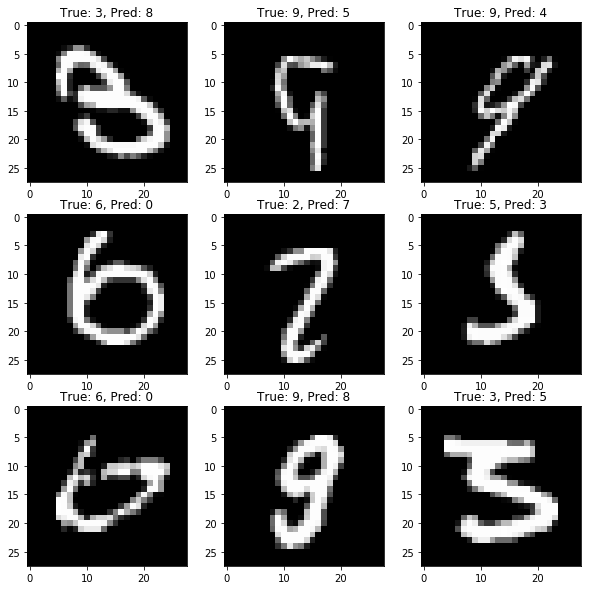

In [67]:
# 識別間違いしたやつをピックアップしてみる
y_pred_label = model.predict_classes(x_test)

idx = (y_pred_label != y_test_label) # 答えが違う添字のやつを抜き出し
x_failed = x_test[idx]
y_true_failed = y_test_label[idx]
y_pred_failed = y_pred_label[idx]

plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_failed[i, :, :, 0], cmap='gray')
    plt.title('True: %d, Pred: %d' % (y_true_failed[i], y_pred_failed[i]))
